# ch08 高性能的Python
对于性能关键应用，总是检查两件事：
+ 使用的是正确的*实现范型*吗？
+ 使用的是正确的*高性能库*吗？

许多高性能库可以用于加速Python代码的执行，介绍如下实用的库：
+ Cython，用于合并Python和C语言静态编译范型；
+ IPython.parallel，用于在本地或者在群集上并行执行代码/函数；
+ numexpr，用于快速数值运算；
+ multiprocessing，Python内建的（本地）并行处理模块；
+ Numba，用于为CPU动态编译Python代码；
+ NumbaPro，用于为多核CPU和GPU动态编译Python代码。

为方便比较相同算法的不同实现，定义一个方便的函数，可以系统地比较在相同或者不同的数据集上执行不同函数的性能：

In [41]:
def perf_comp_data(func_list,data_list,rep=3,number=1):
    '''Function to compare the performance of different functions.
    
    Parameters
    ==========
    func_list : list
        list with function names as strings
    data_list : list
        list with data set names as strings
    rep : int
        number of repetitions of the whole comparison
    number : int
        number of executions for every function
    '''
    from timeit import repeat
    res_list = {}
    for name in enumerate(func_list):
        stmt = name[1] + '(' +data_list[name[0]] + ')'
        setup = "from __main__ import " + name[1] + ', ' + data_list[name[0]]
        results = repeat(stmt = stmt,setup = setup,
                        repeat = rep,number = number)
        res_list[name[1]] = sum(results)/rep
    res_sort = sorted(res_list.iteritems(),
                     key=lambda(k,v):(v,k))
    for item in res_sort:
        rel = item[1]/res_sort[0][1]
        print 'function: '+item[0]+',av.time sec:%9.5f, '%item[1]+'relative: %6.1f'%rel

## 8.1 Python范型与性能
在金融学中与其它科学及数据密集学科一样，大数据集上的数值计算相当费时，举例，在包含50万个数值的数组上求取某个复杂数学表达式的值：

In [2]:
from math import *
def f(x):
    return abs(cos(x))**0.5+sin(2+3*x)

In [4]:
I = 500000
a_py = range(I)

In [21]:
# 包含显示循环的标准Python函数
def f1(a):
    res = []
    for x in a:
        res.append(f(x))
    return res

In [22]:
# 包含隐含循环的迭代子方法
def f2(a):
    return [f(x) for x in a]

In [23]:
# 包含隐含循环、使用eval的迭代子方法
def f3(a):
    ex = 'abs(cos(x))**0.5+sin(2+3*x)'
    return [eval(ex) for x in a]

In [24]:
# Numpy向量化实现
import numpy as np
a_np = np.arange(I)
def f4(a):
    return(np.abs(np.cos(a))**0.5+np.sin(2+3*a))

In [25]:
# numexpr单线程实现
import numexpr as ne
def f5(a): # 单线程
    ex = 'abs(cos(a))**0.5+sin(2+3*a)'
    ne.set_num_threads(1)
    return ne.evaluate(ex)

In [26]:
# numexpr多线程实现
def f6(a): # 多线程
    ex = 'abs(cos(a))**0.5+sin(2+3*a)'
    ne.set_num_threads(16)
    return ne.evaluate(ex)

In [37]:
%%timeit # 记录总执行时间
r1 = f1(a_py)
r2 = f2(a_py)
r3 = f3(a_py)
r4 = f4(a_np)
r5 = f5(a_np)
r6 = f6(a_np)

1 loop, best of 3: 17.4 s per loop


In [32]:
# Numpy函数的allclose可以检查两个（类）ndarray对象是否包含相同数据：
np.allclose(r1,r2)

True

In [33]:
np.allclose(r1,r3)

True

In [34]:
np.allclose(r1,r4)

True

In [35]:
np.allclose(r1,r5)

True

In [36]:
np.allclose(r1,r6)

True

使用自定义的**perf_comp_data**函数，向其提供所有函数和数据集名称：

In [43]:
func_list = ['f1','f2','f3','f4','f5','f6']
data_list = ['a_py','a_py','a_py','a_np','a_np','a_np']
perf_comp_data(func_list,data_list)

function: f6,av.time sec:  0.02252, relative:    1.0
function: f4,av.time sec:  0.07497, relative:    3.3
function: f5,av.time sec:  0.08881, relative:    3.9
function: f2,av.time sec:  0.65218, relative:   29.0
function: f1,av.time sec:  0.69924, relative:   31.0
function: f3,av.time sec: 15.92267, relative:  706.9


## 8.2 内存布局与性能
**Numpy**可以为每个ndarray对象指定所谓的dtype；例如，np.int32或者f8。**Numpy**还允许在初始化ndarray对象时从两种不同的内存布局中选择。根据对象结构，某种布局可能比另一种布局更有优势。下例：

In [44]:
import numpy as np
np.zeros((3,3),dtype = np.float64,order='C')

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

初始化**Numpy ndarray**对象的方式可能（根据数组的大小）对这些数组的操作性能产生显著的影响。下面介绍**ndarray**对象的初始化（例如通过**np.zeros**或者**np.array**）输入参数：

*组成（shape）*

    整数（int）、整数序列或者引用另一个numpy.ndarray
*dtype（可选*

    numpy.dtype--用于numpy.ndarray对象的Numpy特定的数据类型
*顺序（可选）*

    元素在内存中存储的顺序：C表示类似C（行优先），F表示类似Fortran（列优先）

In [45]:
c = np.array([[1.,1.,1.],
            [2.,2.,2.],
            [3.,3.,3.]],order='C')

In [46]:
f = np.array([[1.,1.,1.],
            [2.,2.,2.],
            [3.,3.,3.]],order='F')

In [47]:
x = np.random.standard_normal((3,1500000))
C = np.array(x,order='C')
F = np.array(x,order='F')
x = 0.0

In [48]:
#在类C布局的数组上实施某些标准操作，首先计算总和
%timeit C.sum(axis=0)

100 loops, best of 3: 16.1 ms per loop


In [49]:
%timeit C.sum(axis=1)

100 loops, best of 3: 9.14 ms per loop


In [50]:
#在第一轴上计算总和比第二个轴慢了将近一倍，计算标准差类似：
%timeit C.std(axis=0)

10 loops, best of 3: 74.2 ms per loop


In [51]:
%timeit C.std(axis=1)

10 loops, best of 3: 47.3 ms per loop


In [52]:
#在类F布局的数组上实施某些标准操作，首先计算总和
%timeit F.sum(axis=0)

10 loops, best of 3: 46.4 ms per loop


In [53]:
%timeit F.sum(axis=1)

10 loops, best of 3: 52.7 ms per loop


In [54]:
%timeit F.std(axis=0)

10 loops, best of 3: 177 ms per loop


In [55]:
%timeit F.std(axis=1)

10 loops, best of 3: 166 ms per loop


与类C的布局相比，类F的布局性能更差，两个轴之间的差距很小，但是同样不像其他布局那样显著。结果表明，一般来说，类似C的布局表现更好--这也是**Numpy ndarray**对象没有指定的时候默认使用这种布局的原因。

In [56]:
C = 0.0
F = 0.0

## 8.3 并行计算
### 8.3.1 蒙特卡洛算法
期权的蒙特卡洛估值算法是导致高计算负担的金融算法之一。作为特例，我们选择Black-Scholes-Merton设置下的欧式看涨期权价值蒙特卡洛估算函数。

如果我们值允许欧式看涨期权的行权价可变，实现Black-Scholes-Merton设置下蒙特卡洛估值的函数如下所示：

In [57]:
def bsm_mcs_valuation(strike):
    '''Dynamic Black-Scholes-Merton Monte Carlo estimator for European calls.
    
    Parameters
    ==========
    strike : float
        strike price of the option
    Results
    =======
    value : float
        estimate for present value of call option
    '''
    import numpy as np
    S0 = 100.;T = 1.0;r = 0.05;vola = 0.2
    M = 50;I = 20000
    dt = T / M
    rand = np.random.standard_normal((M+1,I))
    S = np.zeros((M + 1,I))
    S[0] = S0
    for t in range(1,M+1):
        S[t] = S[t-1]*np.exp((r-0.5 * vola ** 2)*dt + vola*np.sqrt(dt)*rand[t])
    value = (np.exp(-r*T)*np.sum(np.maximum(S[-1]-strike,0))/I)
    return value

### 8.3.2 顺序化计算
作为基准用例，我们对不同行权价的100种期权进行估值。**seq_value**函数计算蒙特卡洛估算函数，返回包含行权价和估值结果的列表对象：

In [60]:
def seq_value(n):
    '''Sequential option caluation.
    
    Parameters
    ==========
    n : int
        number of option valuations/strikes
    '''
    strikes = np.linspace(80,120,n)
    option_values = []
    for strike in strikes:
        option_values.append(bsm_mcs_valuation(strike))
    return strikes,option_values

In [97]:
n = 100
%time strikes,option_values_seq = seq_value(n)

Wall time: 9.48 s


Text(0,0.5,u'European call option values')

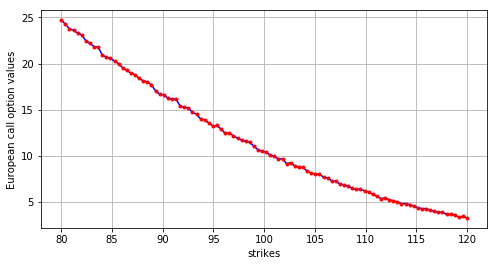

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (8,4))
plt.plot(strikes,option_values_seq,'b')
plt.plot(strikes,option_values_seq,'r.')
plt.grid(True)
plt.xlabel('strikes')
plt.ylabel('European call option values')

### 8.3.3 并行计算
为了并行计算100个权证价值，我们使用**IPython。parallel**和一个本地“群集”。本地群集很容易通过**IPython Notebook**仪表盘中的**Clusters**选项卡启动。使用的线程数量当然取决于运行代码的机器和处理器。

**IPython.parallel**需要哪个集群用于代码并行执行的相关信息。在本例中，集群配置文件保存在“default”（默认）配置文件中。此外，我们需要在群集上生成一个视图：

In [72]:
#from IPython.parallel import Client
from ipyparallel import Client
c = Client(profile="default")
view = c.load_balanced_view()

In [73]:
def par_value(n):
    '''Parallel option caluation.
    
    Parameters
    ==========
    n : int
        number of option valuations/strikes
    '''
    strikes = np.linspace(80,120,n)
    option_values = []
    for strike in strikes:
        value = view.apply_async(bsm_mcs_valuation,strike)
        option_values.append(value)
    c.wait(option_values)
    return strikes,option_values

有两个主要的不同之处需要注意。首先是估值函数通过**view.apply_sync**异步应用到群集视图，这实际上一次性初始化所有期权的并行估值。当然，不是所有期权都可以并行估值，因为（一般）没有足够的核心/线程可用。因此，我们必须等待，知道队列完全结束；这由**Client**对象c的**wait**方法实现。当所有结果可用时，该函数返回，和以前一样，列表对象分别包含行权价和估值结果。

并行估值函数的执行效率在理想的情况下和可用核心（线程）数量呈线性关系。例如，拥有8个可用核心（线程）最多可以将执行时间降低到顺序化计算所需时间的1/8：

In [74]:
%time strikes,option_values_obj = par_value(n)

Wall time: 14.1 s


并行执行不会直接返回期权价值；而是返回更复杂的结果对象：

In [75]:
option_values_obj[0].metadata

{'after': [],
 'completed': datetime.datetime(2017, 12, 17, 11, 19, 17, 211000, tzinfo=tzutc()),
 'data': {},
 'engine_id': 0,
 'engine_uuid': u'9f10bea1-a50dc41040f4216626bcc34d',
 'error': None,
 'execute_input': None,
 'execute_result': None,
 'follow': [],
 'msg_id': u'9f5ce691-4667ec7167531d60766b1238',
 'outputs': [],
 'received': datetime.datetime(2017, 12, 17, 11, 19, 17, 240000, tzinfo=tzutc()),
 'started': datetime.datetime(2017, 12, 17, 11, 19, 12, 294000, tzinfo=tzutc()),
 'status': u'ok',
 'stderr': '',
 'stdout': '',
 'submitted': datetime.datetime(2017, 12, 17, 11, 19, 12, 228000, tzinfo=tzutc())}

估值结果本身保存在对象的result属性中：

In [79]:
option_values_obj[0].result

<bound method AsyncResult.result of <AsyncResult: bsm_mcs_valuation:finished>>

为了生成和顺序化计算相同的结果列表，我们必须从返回对象中读出单个结果：

In [80]:
option_values_par = []
for res in option_values_obj:
    option_values_par.append(res.result)

### 8.3.4 性能比较

In [101]:
n = 50 # number of option valuations
func_list = ['seq_value','par_value']
data_list = 2*['n']

In [102]:
perf_comp_data(func_list,data_list)

function: par_value,av.time sec:  4.37065, relative:    1.0
function: seq_value,av.time sec:  4.78851, relative:    1.1


## 8.4 多处理




## 8.5 动态编译
### 8.5.1 介绍性示例
### 8.5.2 二项式期权定价方法
## 8.6 用Cython进行静态编译
## 8.7 在GPU上生成随机数
## 8.8 结语
## 8.9 延伸阅读